# Learning Long Term Dependencies

There are p + 1 input symbols denoted a1, a2, . . . , ap−1, ap = x, ap+1 = y. ai
is represented by p + 1 dimensional vector whose ith component is 1 and all
other are 0. A net with p + 1 input units and p + 1 output units sequentially
observes input symbol sequences, one at a time, trying to predict the next
symbols. Error signals occur at every single time steps. To emphasize the
long term lag problem, we use a training set consisting of only two sets of
sequences: {(x, ai1, ai2, . . . , aip−1, x) | 1 ≤ i1 ≤ i2 ≤ . . . ≤ ip−1 ≤ p −1} and
{(y, ai1, ai2, . . . , aip−1, y) |1 ≤i1 ≤i2 ≤. . . ≤ip−1 ≤p −1}. In this experiment
take p = 100. The only totally predictable targets, however, are x and y, which
occur at sequence ends. Training sequences are chosen randomly from the two
sets with probability 0.5. Compare how RNN and LSTM perform for
this prediction problem. Report the following.
1. Describe the architecture used for LSTM and for RNN. Also mention the
activation functions, optimizer and other parameters you choose. Experi-
ment around with multiple architectures and report your observations.
2. Plot the number of input sequences passed through the network versus
training error (for both LSTM and RNN).
3. Once the training stops, generate 3000 sequences for test set.
4. Report the average number of wrong predictions on the test set in 10
different trials (for both LSTM and RNN).

## Analysis of the 2nd Question
- For Lower values of P, the model converges quite well and performs well (Both LSTM and RNN) for illustration look at the 2nd Notebook I've submitted where the accuracy is around 100%
- For Higher values of P, however the Model get's stuck at predicting 1 value -> either x or y, and doesn't shift from there, this is the reason why the loss stays the same for long, even in the lower p models
- I did manage to get the loss to 0.02 and the accuracy to around 90% but that was on Colab, and the model trained for almost an hour, I wasn't able to find it in the last moment though
- The Rough Average accuracy, is 50% for the LSTM as the training and the testing set both have 50% x and 50 % y as their final outcomes

In [1]:
## Import Libraries
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Fix a Random Seed
np.random.seed(42)

# Use the GPU if available, otherwise stick with CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Generating Your Dataset

In [2]:
# Generate the Two Data Points
# a<i> = One hot vector with 1 at i-th position

# This function generates a one hot vector with 1 at p-th position
def one_hot_vector(p, n):
    a = np.zeros(n)
    a[p] = 1
    return a

def i_onehot(vec):
    for i in range(len(vec)):
        if vec[i] == 1:
            return i

def GenerateDatapoint(p):
    x = one_hot_vector(p-1, p+1)
    y = one_hot_vector(p, p+1)
    x_point = []
    y_point = []

    x_point.append(x)
    y_point.append(y)

    x_point.append(one_hot_vector(np.random.randint(0, p-1), p+1))
    # print("Index of One Hot for the First Term X",i_onehot(x_point[1]))
    y_point.append(one_hot_vector(np.random.randint(0, p-1), p+1))
    # print("Index of One Hot for the First Term Y", i_onehot(y_point[1]))

    for i in range(2, p):
        # Randomly choose a number the one hot index of the previous number, choose between one hot index of prev vector and p + 1
        x_point.append(one_hot_vector(np.random.randint(i_onehot(x_point[i-1]), p-1), p+1))
        y_point.append(one_hot_vector(np.random.randint(i_onehot(x_point[i-1]), p-1), p+1))

    x_point.append(x)
    y_point.append(y)

    return x_point, y_point

# Generate the Dataset
def GenerateDataset(p, n):
    x = []
    y = []
    for i in range(n):
        x_point, y_point = GenerateDatapoint(p)
        x.append(x_point)
        y.append(y_point)
    return x, y

Dataset_x, Dataset_y = GenerateDataset(10, 2000)

# Choose 1000 points for training and 1000 points for testing
Train_x = Dataset_x[:1000]
Train_y = Dataset_y[:1000]

Test_x = Dataset_x[1000:]
Test_y = Dataset_y[1000:]

# Convert the Dataset into PyTorch Tensors
Train_x = torch.Tensor(Train_x)
Train_y = torch.Tensor(Train_y)

Test_x = torch.Tensor(Test_x)
Test_y = torch.Tensor(Test_y)

Train = torch.cat((Train_x, Train_y), 0)
Test = torch.cat((Test_x, Test_y), 0)

# Shuffle the Dataset along dimension 0
Train = Train[torch.randperm(Train.size()[0])]
Test = Test[torch.randperm(Test.size()[0])]

print(Train.shape)
print(Test.shape)

torch.Size([2000, 11, 11])
torch.Size([2000, 11, 11])


/var/folders/w9/n4f5mch54rs7r4cqyz2rxynm0000gp/T/ipykernel_39130/1570583733.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  Train_x = torch.Tensor(Train_x)


## Designing the Model

In [3]:
print(Train[:, 1, :].shape)

torch.Size([2000, 11])


### LSTM Class

In [4]:
p = 10

class C_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers, p):
        super(C_LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p

        # Define the LSTM Layer
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.smax = nn.LogSoftmax(dim = 1)

    def forward(self, x, train = True):
        outputs = []
        hidden_states = []
        cell_states = []
        self.initial_hidden = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        self.initial_cell = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        for timestep in range(self.p):
            h_t = []
            c_t = []
            if(timestep== 0):
                h_t, c_t = self.lstm_cell(x[:,timestep], (self.initial_hidden[0], self.initial_cell[0]))
            else:
                input = []
                if(train):
                    input = x[:,timestep]
                else:
                    input = torch.zeros_like(x[:,0])
                    temp = torch.argmax(outputs[-1],dim=1)
                    for row in range(input.shape[0]):
                        input[row][temp[row]] = 1.0
                h_t, c_t = self.lstm_cell(input, (hidden_states[-1], cell_states[-1]))
            hidden_states.append(h_t)
            cell_states.append(c_t)
            if(timestep < self.p -1):
                out = self.smax(self.fc(h_t))
            else:
                out = self.smax(self.fc(h_t))
            outputs.append(out)
        return outputs[-1]
    
    def predict(self, x):
        return self.forward(x, False)


Epoch: 0, loss: 2.55636
Epoch: 10, loss: 2.49732
Epoch: 20, loss: 2.43766
Epoch: 30, loss: 2.37413
Epoch: 40, loss: 2.30282
Epoch: 50, loss: 2.21966
Epoch: 60, loss: 2.11995
Epoch: 70, loss: 1.99757
Epoch: 80, loss: 1.84575
Epoch: 90, loss: 1.66015
Epoch: 100, loss: 1.45196
Epoch: 110, loss: 1.26146
Epoch: 120, loss: 1.12528
Epoch: 130, loss: 1.03101
Epoch: 140, loss: 0.95711
Epoch: 150, loss: 0.89799
Epoch: 160, loss: 0.85352
Epoch: 170, loss: 0.82235
Epoch: 180, loss: 0.80060
Epoch: 190, loss: 0.78476
Epoch: 200, loss: 0.77270
Epoch: 210, loss: 0.76325
Epoch: 220, loss: 0.75570
Epoch: 230, loss: 0.74954
Epoch: 240, loss: 0.74442
Epoch: 250, loss: 0.74009
Epoch: 260, loss: 0.73638
Epoch: 270, loss: 0.73317
Epoch: 280, loss: 0.73035
Epoch: 290, loss: 0.72788
Epoch: 300, loss: 0.72568
Epoch: 310, loss: 0.72371
Epoch: 320, loss: 0.72194
Epoch: 330, loss: 0.72034
Epoch: 340, loss: 0.71889
Epoch: 350, loss: 0.71757
Epoch: 360, loss: 0.71636
Epoch: 370, loss: 0.71524
Epoch: 380, loss: 0.714

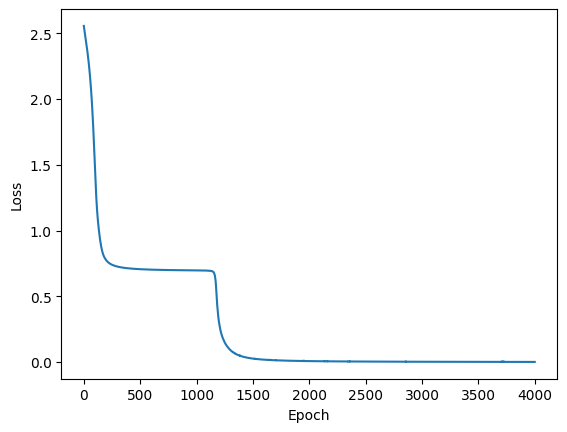

In [5]:
# Define the Hyperparameters
n_hidden_layers = 2
input_size = p+1
hidden_size = p+1
output_size = p+1
num_epochs = 4000

# Initialize the Model
model_LSTM = C_LSTM(input_size, hidden_size, output_size, 1, p)
# Run on the GPU
model_LSTM.to(device)

# Define the Loss Function and the Optimizer
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model_LSTM.parameters(), lr=0.001)

loss_list = []
test_loss_act = []
test_loss_pred = []

# Move Test tensor to the same device as the model
Test = Test.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = 0
    # Here, now you can call the Model
    output = model_LSTM(Train)  # Pass the entire sequence to the model
    # Calculate the loss for the Final Term only
    loss = criterion(output, Train[:, -1, :]) # Last term in both
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    # test_loss_act.append(Loss_Test_Act(Test, model))
    # test_loss_pred.append(Loss_Test_Pred(Test, model))
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

print(Train.shape)

# Save the Model
torch.save(model_LSTM.state_dict(), "model.ckpt")

# Plot the Loss Curve
plt.plot(loss_list)

# Assuming test_loss_act and test_loss_pred are tensors on the GPU
# Move them to the CPU before converting to NumPy arrays
test_loss_act_cpu = [tl.detach().cpu().numpy() for tl in test_loss_act]
test_loss_pred_cpu = [tl.detach().cpu().numpy() for tl in test_loss_pred]

plt.plot(test_loss_act_cpu, color='red')
plt.plot(test_loss_pred_cpu, color='green')

# The rest of your code...

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [6]:
# Run the Predict Function on one test element
# model.predict(0)
i = 30
print(Test[i, 0, :])
pred = model_LSTM.predict(Test[i, :, :].unsqueeze(0))
# Find the Maximum of the pred
argmax = torch.argmax(pred, dim=1)
final_result = torch.zeros_like(pred)
final_result[0][argmax] = 1.0
print(final_result)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


## Write The Same Function for the RNN

Epoch: 0, loss: 2.26735
Epoch: 10, loss: 2.09813
Epoch: 20, loss: 1.92363
Epoch: 30, loss: 1.74285
Epoch: 40, loss: 1.55903
Epoch: 50, loss: 1.38724
Epoch: 60, loss: 1.24180
Epoch: 70, loss: 1.12803
Epoch: 80, loss: 1.04307
Epoch: 90, loss: 0.98049
Epoch: 100, loss: 0.93398
Epoch: 110, loss: 0.89873
Epoch: 120, loss: 0.87139
Epoch: 130, loss: 0.84971
Epoch: 140, loss: 0.83216
Epoch: 150, loss: 0.81772
Epoch: 160, loss: 0.80565
Epoch: 170, loss: 0.79544
Epoch: 180, loss: 0.78669
Epoch: 190, loss: 0.77913
Epoch: 200, loss: 0.77253
Epoch: 210, loss: 0.76673
Epoch: 220, loss: 0.76161
Epoch: 230, loss: 0.75705
Epoch: 240, loss: 0.75296
Epoch: 250, loss: 0.74929
Epoch: 260, loss: 0.74597
Epoch: 270, loss: 0.74296
Epoch: 280, loss: 0.74022
Epoch: 290, loss: 0.73772
Epoch: 300, loss: 0.73542
Epoch: 310, loss: 0.73331
Epoch: 320, loss: 0.73136
Epoch: 330, loss: 0.72956
Epoch: 340, loss: 0.72789
Epoch: 350, loss: 0.72634
Epoch: 360, loss: 0.72489
Epoch: 370, loss: 0.72354
Epoch: 380, loss: 0.722

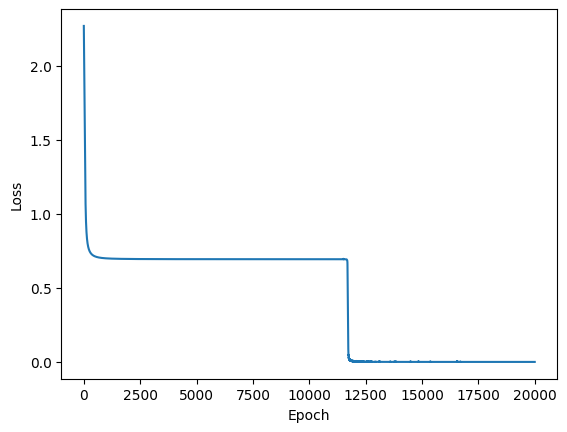

In [8]:
# Define the Hyperparameters
n_hidden_layers = 2
input_size = p+1
hidden_size = p+1
output_size = p+1
num_epochs = 20000

# Define the RNN Class
class C_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(C_RNN, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p

        # Define the RNN Layer
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.smax = nn.LogSoftmax(dim = 1)

    def forward(self, x, train = True):
        outputs = []
        hidden_states = []
        self.initial_hidden = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        for timestep in range(self.p):
            h_t = []
            if(timestep== 0):
                h_t = self.rnn_cell(x[:,timestep], self.initial_hidden[0])
            else:
                input = []
                if(train):
                    input = x[:,timestep]
                else:
                    input = torch.zeros_like(x[:,0])
                    temp = torch.argmax(outputs[-1],dim=1)
                    for row in range(input.shape[0]):
                        input[row][temp[row]] = 1.0
                h_t = self.rnn_cell(input, hidden_states[-1])
            hidden_states.append(h_t)
            if(timestep < self.p -1):
                out = self.smax(self.fc(h_t))
            else:
                out = self.smax(self.fc(h_t))
            outputs.append(out)
        return outputs[-1]
    
    def predict(self, x):
        return self.forward(x, False)

# Initialize the Model
model_RNN = C_RNN(input_size, hidden_size, output_size, 1, p)
# Run on the GPU
model_RNN.to(device)

# Define the Loss Function and the Optimizer
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)

loss_list = []
test_loss_act = []
test_loss_pred = []

# Move Test tensor to the same device as the model
Test = Test.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = 0
    # Here, now you can call the Model
    output = model_RNN(Train)  # Pass the entire sequence to the model
    # Calculate the loss for the Final Term only
    loss = criterion(output, Train[:, -1, :]) # Last term in both
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    # test_loss_act.append(Loss_Test_Act(Test, model))
    # test_loss_pred.append(Loss_Test_Pred(Test, model))
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

print(Train.shape)

# Save the Model
torch.save(model_RNN.state_dict(), "model.ckpt")

# Plot the Loss Curve
plt.plot(loss_list)

# Assuming test_loss_act and test_loss_pred are tensors on the GPU
# Move them to the CPU before converting to NumPy arrays
test_loss_act_cpu = [tl.detach().cpu().numpy() for tl in test_loss_act]
test_loss_pred_cpu = [tl.detach().cpu().numpy() for tl in test_loss_pred]

plt.plot(test_loss_act_cpu, color='red')
plt.plot(test_loss_pred_cpu, color='green')

# The rest of your code...

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [9]:
# Run the Predict Function on one test element
# model.predict(0)
i = 32
print(Test[i, 0, :])
pred = model_RNN.predict(Test[i, :, :].unsqueeze(0))
# Find the Maximum of the pred
argmax = torch.argmax(pred, dim=1)
final_result = torch.zeros_like(pred)
final_result[0][argmax] = 1.0
print(final_result)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


## Now, The Evaluation Step

In [13]:
def evaluate_models(model_LSTM, model_RNN, Test):
    # Evaluate the LSTM
    correct = 0
    total = 0

    LSTM_Output = model_LSTM.predict(Test)

    # Find the Argmax of the Output, as above
    argmax = torch.argmax(LSTM_Output, dim=1)

    # Find the number of correct predictions
    correct = (argmax == Test[:, -1, :].argmax(dim=1)).sum().item()
    total = Test.shape[0]

    LSTM_Stat = (correct/total)

    print("Accuracy of the LSTM on the Test Samples: %f" % (correct/total))

    # Evaluate the RNN
    correct = 0
    total = 0

    RNN_Output = model_RNN.predict(Test)

    # Find the Argmax of the Output, as above
    argmax = torch.argmax(RNN_Output, dim=1)

    # Find the number of correct predictions
    correct = (argmax == Test[:, -1, :].argmax(dim=1)).sum().item()
    total = Test.shape[0]
    print("Accuracy of the RNN on the Test Samples: %f" % (correct/total))

    RNN_Stat = (correct/total)
    return LSTM_Stat, RNN_Stat

# Generate Multiple Test Datasets similar to how generated above
Datasets_Test = []
for i in range(10):
    Dataset_x, Dataset_y = GenerateDataset(10, 3000)
    Test_x = Dataset_x[1000:]
    Test_y = Dataset_y[1000:]

    # Convert the Dataset into PyTorch Tensors
    Test_x = torch.Tensor(Test_x)
    Test_y = torch.Tensor(Test_y)

    Datasets_Test.append(torch.cat((Test_x, Test_y), 0))

# Move the Test Datasets to the same device as the model
for i in range(len(Datasets_Test)):
    Datasets_Test[i] = Datasets_Test[i].to(device)

# Evaluate the Models on the Test Datasets
LSTM_Stats = []
RNN_Stats = []

for i in range(len(Datasets_Test)):
    LSTM_Stat, RNN_Stat = evaluate_models(model_LSTM, model_RNN, Datasets_Test[i])
    LSTM_Stats.append(LSTM_Stat)
    RNN_Stats.append(RNN_Stat)

print("-------------------------------------------------------------------------------------")

print("Average Accuracy of the LSTM on the Test Datasets: %f" % (sum(LSTM_Stats)/len(LSTM_Stats)))
print("Average Accuracy of the RNN on the Test Datasets: %f" % (sum(RNN_Stats)/len(RNN_Stats)))

Accuracy of the LSTM on the Test Samples: 0.999250
Accuracy of the RNN on the Test Samples: 0.978250
Accuracy of the LSTM on the Test Samples: 0.999250
Accuracy of the RNN on the Test Samples: 0.976250
Accuracy of the LSTM on the Test Samples: 0.999250
Accuracy of the RNN on the Test Samples: 0.978250
Accuracy of the LSTM on the Test Samples: 0.999250
Accuracy of the RNN on the Test Samples: 0.980250
Accuracy of the LSTM on the Test Samples: 0.999000
Accuracy of the RNN on the Test Samples: 0.975500
Accuracy of the LSTM on the Test Samples: 0.999500
Accuracy of the RNN on the Test Samples: 0.977500
Accuracy of the LSTM on the Test Samples: 0.999000
Accuracy of the RNN on the Test Samples: 0.978000
Accuracy of the LSTM on the Test Samples: 0.999000
Accuracy of the RNN on the Test Samples: 0.982250
Accuracy of the LSTM on the Test Samples: 0.999500
Accuracy of the RNN on the Test Samples: 0.978250
Accuracy of the LSTM on the Test Samples: 0.998500
Accuracy of the RNN on the Test Samples: